In [116]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import PowerTransformer

The aim of this script is to predict customer churn of a bank within 6 months based on customer attributes

# Import Customer Data, Get General Information

In [117]:
original_data = pd.read_csv('Churn_Modelling.csv')
data = original_data.drop_duplicates()
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


# View Sample of the Data

In [119]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Correlations of the Independent Variables to the Dependent Variable

In [120]:
corr_matrix = data.corr()

In [121]:
corr_matrix["Exited"].sort_values(ascending=False).to_frame('Correlations')

,Correlations
Exited,1.000000
Age,0.285323
Balance,0.118533
EstimatedSalary,0.012097
HasCrCard,-0.007138
Tenure,-0.014001
CreditScore,-0.027094
NumOfProducts,-0.047820
IsActiveMember,-0.156128


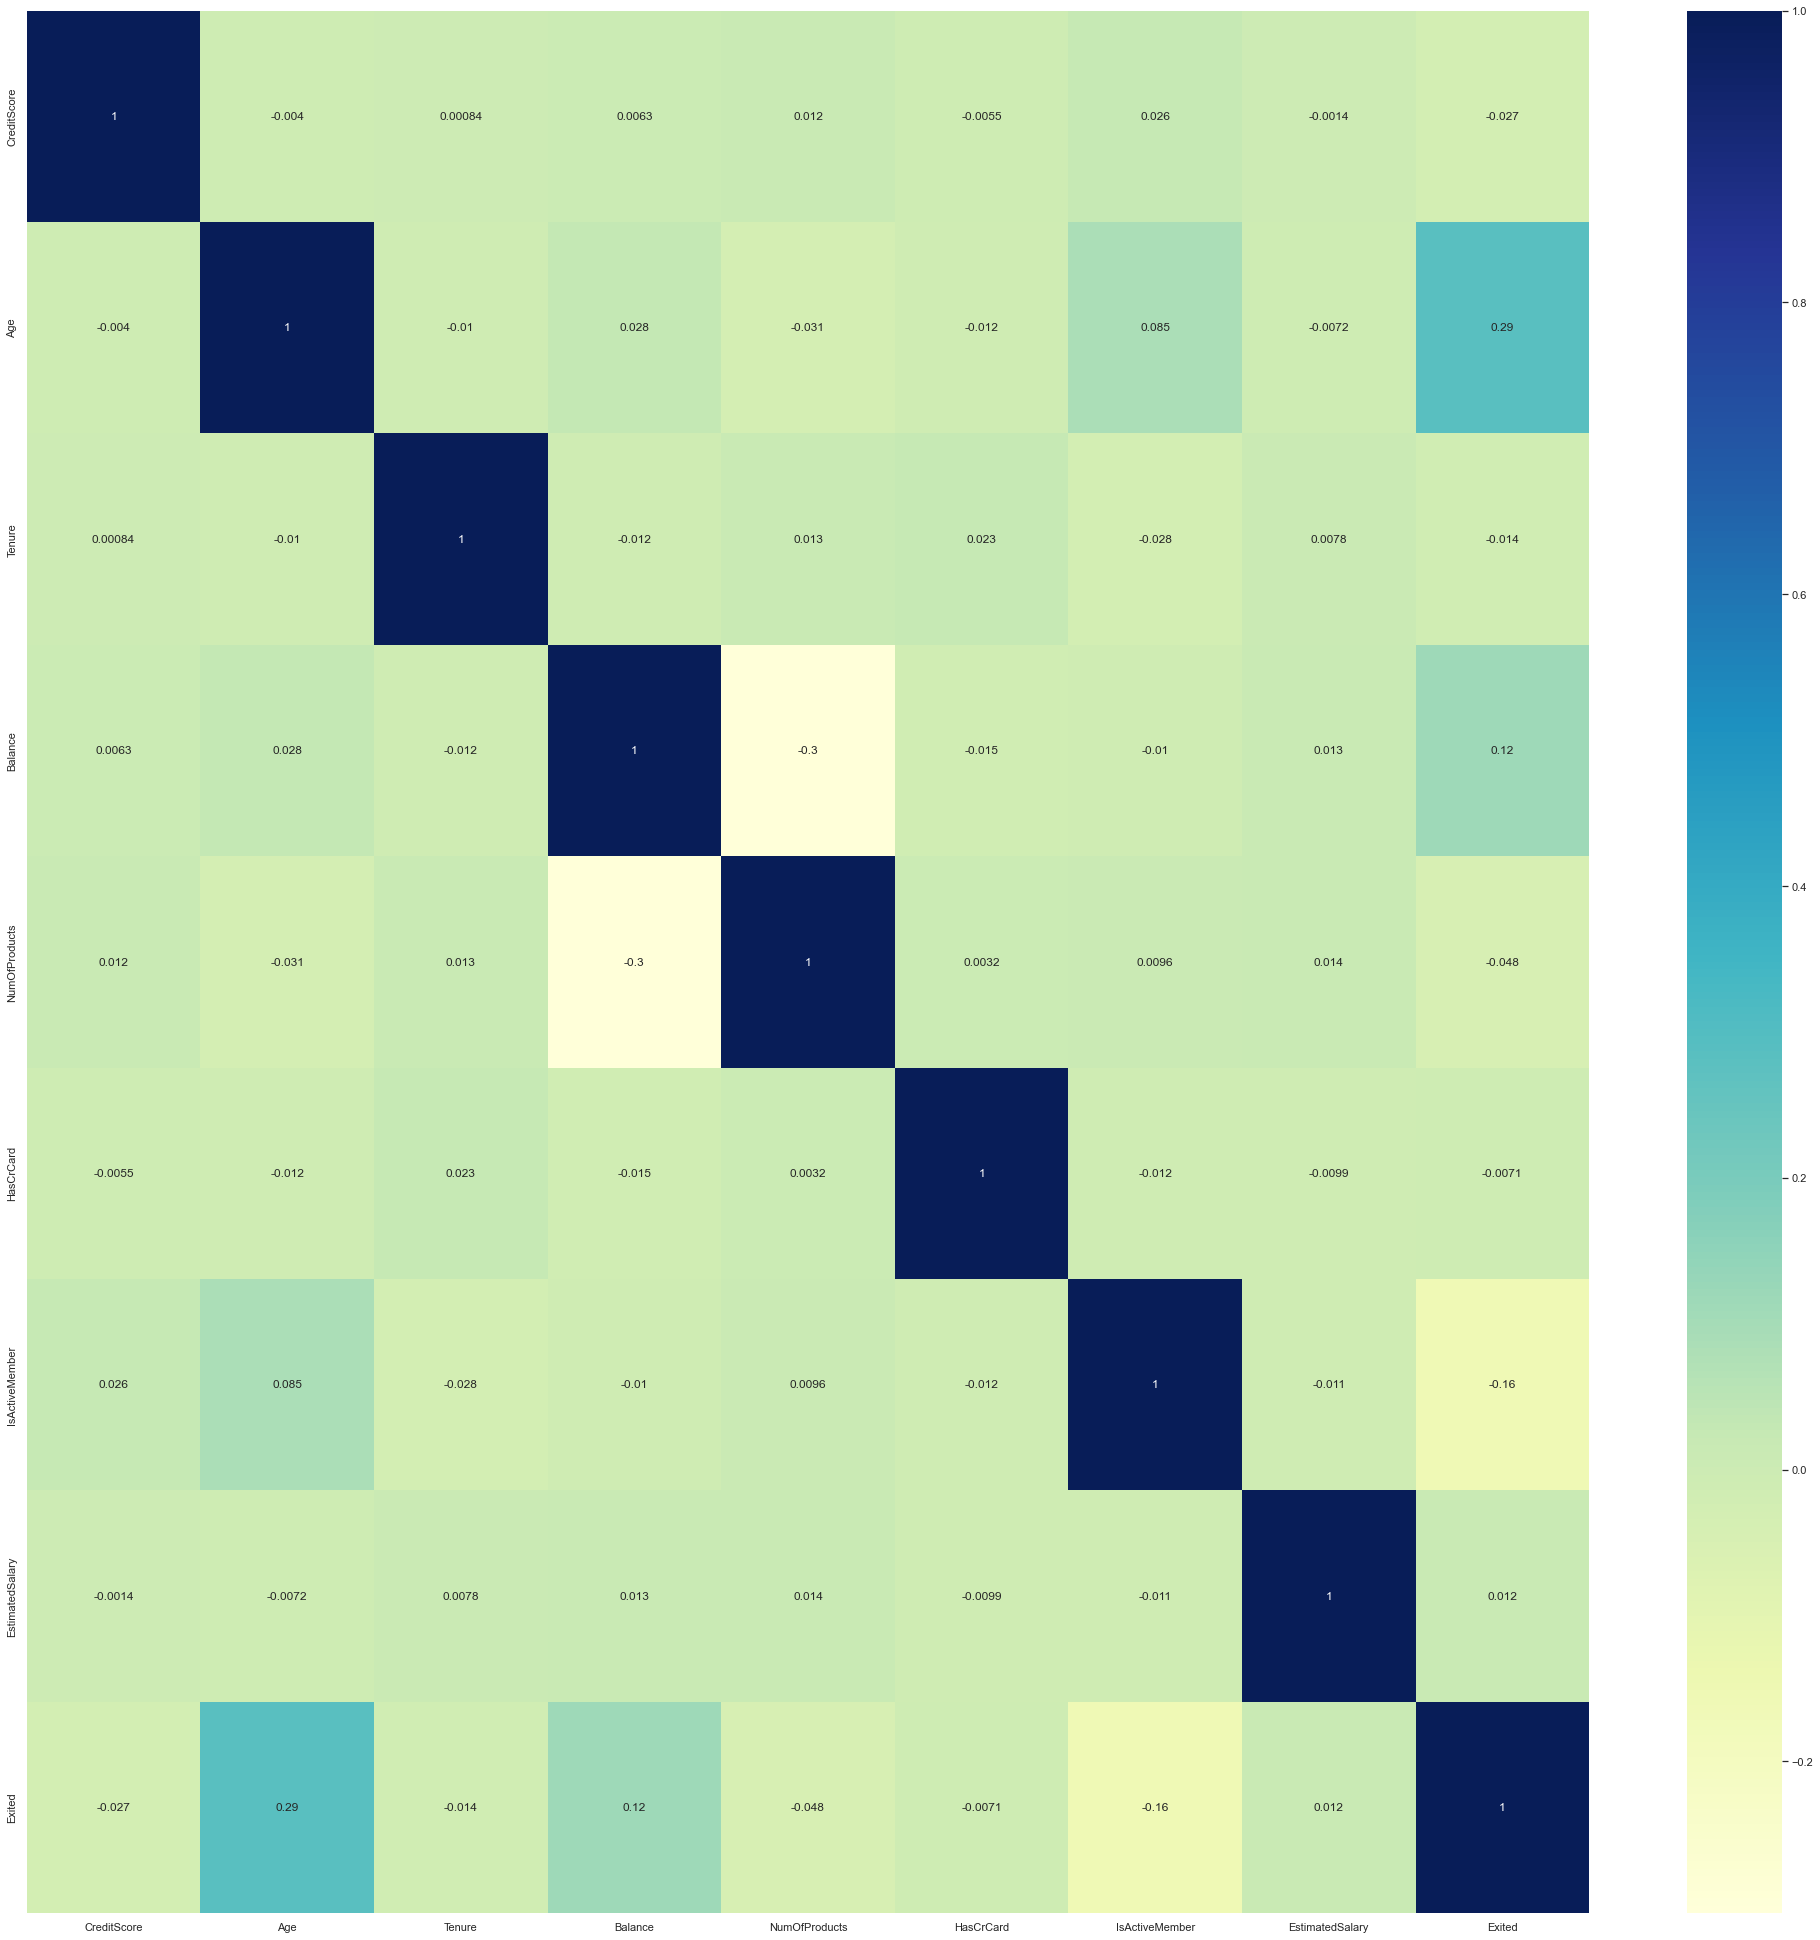

In [122]:
plt.figure(figsize = (35,35))
correlation_plot = sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True)
plt.show()

# Separate Independent/Dependent Variables in the Train Set

In [123]:
data_labels = data["Exited"]
data = data.drop("Exited", axis=1)

# Split the Data into Train/Test Splits

In [124]:
x_train, x_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.2)

# Split Train Dataset based on variable types (Categorical vs Numeric)

In [125]:
data_char = x_train.loc[:,x_train.dtypes==object]
data_num = x_train.loc[:,x_train.dtypes!=object]

# Show Character Variables

In [126]:
data_char.head()

,Geography,Gender
216,France,Male
8891,Spain,Male
9721,France,Female
4369,France,Female
2020,Germany,Female


# Show Numeric Variables

In [127]:
data_num.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
216,695,46,7,49512.55,1,1,0,133007.34
8891,534,34,5,170600.78,1,0,1,5240.53
9721,560,38,5,83714.41,1,1,1,33245.97
4369,662,22,2,126362.57,2,1,1,97382.80
2020,627,30,6,57809.32,1,1,0,188258.49


# Data Manipulation Pipeline (Handling Missing Values, Feature Selection, Encoding for Character Variables, Feature Scaling for Numeric Variables)

In [128]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


num_vars = list(data_num)
char_vars = list(data_char)

numerical_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_vars)),
    ('imputer',SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('feature_scaler', MaxAbsScaler()),
    ('log_transformer',PowerTransformer()),
    ('feature_selection', PCA(n_components=0.95))
])       

categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(char_vars)),
    ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
]) 

full_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", numerical_pipeline),
    ("categorical_pipeline", categorical_pipeline)
])

prepared_data = full_pipeline.fit_transform(x_train)
prepared_data_test = full_pipeline.transform(x_test)


# Train & Evaluate ML Model

### Random Forest model will be used to predict customer churn

In [129]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=200, random_state=0) 
classifier.fit(prepared_data, y_train) 
predictions = classifier.predict(prepared_data_test)

### Get Model Metrics

In [130]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test,predictions )) 
print(accuracy_score(y_test, predictions ))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1592
           1       0.76      0.39      0.52       408

    accuracy                           0.85      2000
   macro avg       0.81      0.68      0.72      2000
weighted avg       0.84      0.85      0.83      2000

0.8505


### Feature Importances

<AxesSubplot:>

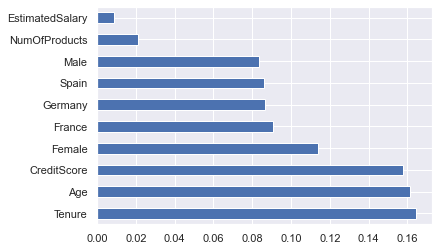

In [147]:
index = ['CreditScore','France','Spain','Germany','Female','Male','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
feat_importances = pd.Series(classifier.feature_importances_, index = index)
feat_importances.nlargest(10).plot(kind='barh')

# Generate A Churn Prediction Using the Final ML Model

### Create new data for a customer and see what the model predicts

In [132]:
customer = pd.DataFrame()
customer["CreditScore"] = [750]
customer["Geography"] = ['Germany']
customer["Gender"] = ['Male']
customer["Age"] = [47]
customer["Tenure"] = [8]
customer["Balance"] = [150986.45]
customer["NumOfProducts"] = [3]
customer["HasCrCard"] = [1]
customer["IsActiveMember"] = [1]
customer["EstimatedSalary"] = [117000]	

print(customer)

   CreditScore Geography Gender  Age  Tenure    Balance  NumOfProducts  \
0          750   Germany   Male   47       8  150986.45              3   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               1           117000  


In [133]:
prepared_sample = full_pipeline.transform(customer)
behaviour_estimate = classifier.predict(prepared_sample)

Generate Churn Prediction

In [134]:
print(behaviour_estimate)

[1]


The model predicts that this customer will leave the bank within the next 6 months